# 04. Feature Engineering

## Objective
- Develop features that capture seasonal and temporal patterns in electricity consumption.
- Prepare structured and informative input variables for Machine Learning and Deep Learning models.

## 1. Setup and Load Dataset

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
import os
import sys
sys.path.append(os.path.abspath('../'))
from src.data_loader import load_data, save_file
from src.features import add_time_features, add_lag_features, add_rolling_features

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

print(f"Python version: {sys.version.split()[0]}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Python version: 3.10.11
Pandas version: 2.1.4
NumPy version: 1.26.4


In [2]:
# Load raw data using custom loader
try:
    df = load_data('data/processed/electricity_data_cleaned.parquet')
    print("✅ Data loaded successfully!")
    print(f"📊 Shape: {df.shape}")
    print(f"🕒 Time span: {df.index.min()} → {df.index.max()}")
    if not df.index.freq:
        df = df.asfreq("1H")
    print(f"🕒 Frequency: {df.index.freq}")
except Exception as e:
    print(f"❌ Error: {e}")

👉 Loading: data/processed/electricity_data_cleaned.parquet
✅ Data loaded successfully!
📊 Shape: (35065, 370)
🕒 Time span: 2011-01-01 00:00:00 → 2015-01-01 00:00:00
🕒 Frequency: <Hour>


In [3]:
df_total = pd.DataFrame({
    "total_load": df.sum(axis=1)
}, index=df.index)

df_total.head()

,total_load
Timestamp,
2011-01-01 00:00:00,207058.270272
2011-01-01 01:00:00,265378.510747
2011-01-01 02:00:00,263924.219533
2011-01-01 03:00:00,266306.134264
2011-01-01 04:00:00,259854.210701


## 2. Time-Based Features
- Hour of day
- Day of week
- Month
- Weekend indicator

In [4]:
df_features = df_total.copy()
df_features = add_time_features(df_features)
df_features.head()

,total_load,hour,weekday,month,is_weekend
Timestamp,,,,,
2011-01-01 00:00:00,207058.270272,0,5,1,1
2011-01-01 01:00:00,265378.510747,1,5,1,1
2011-01-01 02:00:00,263924.219533,2,5,1,1
2011-01-01 03:00:00,266306.134264,3,5,1,1
2011-01-01 04:00:00,259854.210701,4,5,1,1


## 3. Lag Features
- Lag 1 hour
- Lag 24 hours (1 day)
- Lag 168 hours (1 week)

In [5]:
df_features = add_lag_features(
    df_features,
    lags=(1, 24, 168),
    target_col="total_load"
)
df_features.head()

,total_load,hour,weekday,month,is_weekend,lag_1,lag_24,lag_168
Timestamp,,,,,,,,
2011-01-01 00:00:00,207058.270272,0,5,1,1,NaN,NaN,NaN
2011-01-01 01:00:00,265378.510747,1,5,1,1,207058.270272,NaN,NaN
2011-01-01 02:00:00,263924.219533,2,5,1,1,265378.510747,NaN,NaN
2011-01-01 03:00:00,266306.134264,3,5,1,1,263924.219533,NaN,NaN
2011-01-01 04:00:00,259854.210701,4,5,1,1,266306.134264,NaN,NaN


## 4. Rolling Statistics
- Rolling mean (24h, 168h)
- Rolling standard deviation

In [6]:
df_features = add_rolling_features(
    df_features,
    sizes=(24, 168),
    target_col="total_load"
)
df_features.tail()

,total_load,hour,weekday,month,is_weekend,lag_1,lag_24,lag_168,rolling_24_mean,rolling_24_std,rolling_168_mean,rolling_168_std
Timestamp,,,,,,,,,,,,
2014-12-31 20:00:00,667804.769894,20,2,12,0,811509.255195,1.012113e+06,716135.722764,760229.771158,195467.364824,735249.187932,234397.508134
2014-12-31 21:00:00,624989.774607,21,2,12,0,667804.769894,9.789456e+05,673336.670830,745481.611612,191561.697472,734961.408788,234503.630439
2014-12-31 22:00:00,580852.784441,22,2,12,0,624989.774607,8.873746e+05,630969.439682,732709.869325,191907.987886,734663.095364,234668.530238
2014-12-31 23:00:00,513952.190189,23,2,12,0,580852.784441,7.359515e+05,541478.420701,723459.897303,197026.865310,734499.248754,234813.784829
2015-01-01 00:00:00,124214.199215,0,3,1,0,513952.190189,6.126145e+05,424848.218855,703109.884549,231227.370064,732709.760542,238307.289955


## 5. Feature Selection
- Phân tích tương quan
- Loại bỏ feature dư thừa

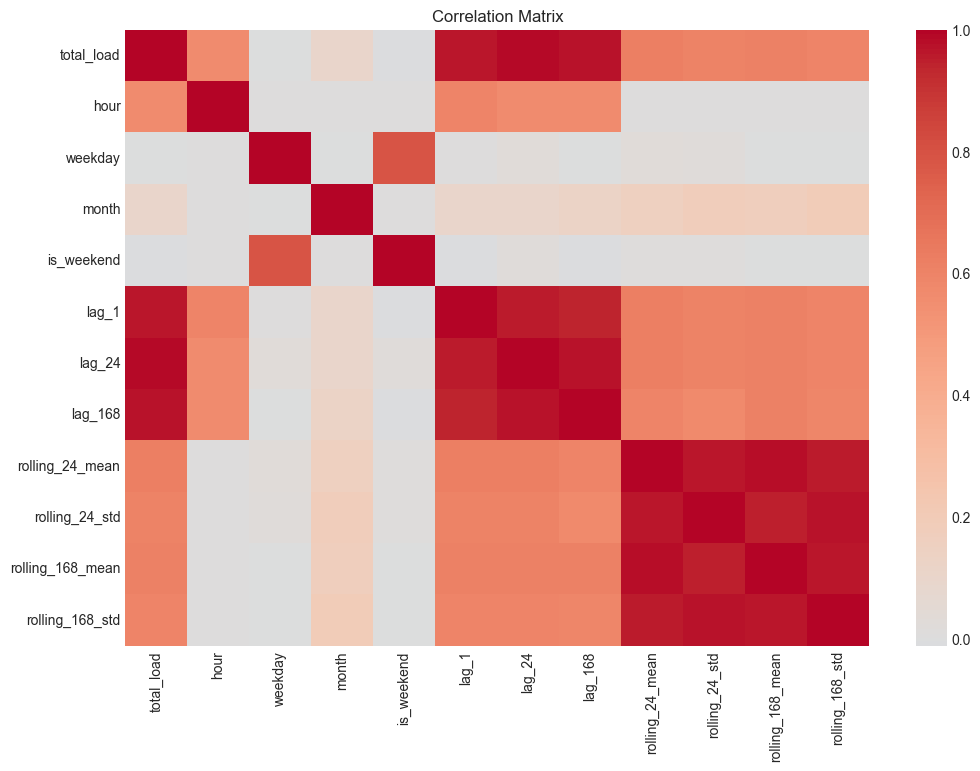

In [7]:
corr = df_features.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

In [8]:
corr["total_load"].sort_values(ascending=False)

total_load          1.000000
lag_24              0.989455
lag_168             0.972606
lag_1               0.968167
rolling_24_mean     0.623555
rolling_168_mean    0.611794
rolling_24_std      0.602508
rolling_168_std     0.594025
hour                0.562508
month               0.096609
weekday            -0.002945
is_weekend         -0.011334
Name: total_load, dtype: float64

In [9]:
# Features to drop
features_to_drop = [
    "weekday",
    "is_weekend",
    "month",
    "lag_1",
    "rolling_168_mean",
    "rolling_168_std"
]

# Drop them
df_features = df_features.drop(columns=features_to_drop)

df_features.head()

,total_load,hour,lag_24,lag_168,rolling_24_mean,rolling_24_std
Timestamp,,,,,,
2011-01-01 00:00:00,207058.270272,0,NaN,NaN,NaN,NaN
2011-01-01 01:00:00,265378.510747,1,NaN,NaN,NaN,NaN
2011-01-01 02:00:00,263924.219533,2,NaN,NaN,NaN,NaN
2011-01-01 03:00:00,266306.134264,3,NaN,NaN,NaN,NaN
2011-01-01 04:00:00,259854.210701,4,NaN,NaN,NaN,NaN


## 6. Feature Dataset Overview
- Kiểm tra missing sau khi tạo feature
- Shape cuối cùng

In [10]:
df_features.isna().sum()

total_load           0
hour                 0
lag_24              24
lag_168            168
rolling_24_mean     23
rolling_24_std      23
dtype: int64

In [11]:
df_features = df_features.dropna()
df_features.isna().sum()

total_load         0
hour               0
lag_24             0
lag_168            0
rolling_24_mean    0
rolling_24_std     0
dtype: int64

In [12]:
df_features.shape

(34897, 6)

In [13]:
df_features.head()

,total_load,hour,lag_24,lag_168,rolling_24_mean,rolling_24_std
Timestamp,,,,,,
2011-01-08 00:00:00,345613.206498,0,342867.230284,207058.270272,480062.782207,119072.049036
2011-01-08 01:00:00,290139.936685,1,293191.647227,265378.510747,479935.627601,119281.726057
2011-01-08 02:00:00,277300.122429,2,282174.107776,263924.219533,479732.544878,119636.684309
2011-01-08 03:00:00,274216.737028,3,280968.150144,266306.134264,479451.235998,120131.286295
2011-01-08 04:00:00,276134.089243,4,275536.068134,259854.210701,479476.153544,120087.205335


In [14]:
df_total.head()

,total_load
Timestamp,
2011-01-01 00:00:00,207058.270272
2011-01-01 01:00:00,265378.510747
2011-01-01 02:00:00,263924.219533
2011-01-01 03:00:00,266306.134264
2011-01-01 04:00:00,259854.210701


## Save data

In [16]:
save_file(df_total,"total_load.parquet")
save_file(df_features,"total_features.parquet")

File saved as: ../data/processed\total_load.parquet
File saved as: ../data/processed\total_features.parquet


## 7. Conclusion
Based on correlation analysis, features with weak predictive power such as `weekday`, `is_weekend`, and `month` were removed.

Additionally, redundant features with high multicollinearity (e.g., `lag_1`, `rolling_168_mean`, `rolling_168_std`) were excluded to simplify the model and reduce overfitting risk.

After feature selection, rows containing missing values generated by lag and rolling window operations were removed using `dropna()`.

The final feature set includes:
- `hour`
- `lag_24`
- `lag_168`
- `rolling_24_mean`
- `rolling_24_std`

This refined dataset captures daily and weekly seasonality, short-term dependency, and short-term variability, making it suitable for time series forecasting models.